Plots for learning harmonic functions
with neural networks.

## Load libraries

In [1]:
%load_ext autoreload
%autoreload 2

In [108]:
from collections import defaultdict
import dataclasses
import json
import logging
import os
import pickle
import sys
import tempfile
from typing import Callable, Union

import mlflow

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import PIL
from tqdm import tqdm

import pytorch_lightning as pl
from pytorch_lightning.callbacks.early_stopping import EarlyStopping
logging.getLogger("pytorch_lightning").setLevel(logging.WARNING)

import torch
import torch.nn as nn
import torch.nn.functional as F

import jax
import jax.numpy as jnp
os.environ["XLA_PYTHON_CLIENT_PREALLOCATE"] = "false"

from simple_parsing.helpers import Serializable

In [109]:
sys.path.append("..")

import src.experiments.harmonics.bw_loss as bw_loss
from src.experiments.harmonics.run_experiment import ExperimentConfig
from src.experiments.harmonics.fc_net import FCNet, FCNetConfig
from src.experiments.harmonics.data import HypercubeDataModule
from src.experiments.harmonics.harmonics import (
    HarmonicFn,
    HarmonicFnTrainable,
    HarmonicFnConfig,
)
from src.experiments.harmonics.poly import ChebPoly, ChebPolyConfig
import src.utils as utils
utils.mlflow_init()

## Utility code

In [110]:
def get_mse(
    model: pl.LightningModule,
    dl: torch.utils.data.DataLoader,
):
    return pl.Trainer(
        enable_progress_bar=False,
    ).test(
        model=model,
        dataloaders=dl,
        verbose=False,
    )[0]['test_mse']


@dataclasses.dataclass(frozen=True)
class LSData:
    ns: np.ndarray
    val_mses: np.ndarray
    
    noise_std: float
    
def run_lstsq_exp(
    ns: list[int],
    true_fn: Union[HarmonicFn, ChebPoly],
    estimator: Callable[[np.ndarray, np.ndarray], pl.LightningModule],
    n_trials: int = 1,
    noise_std: float = 0.0,
) -> np.ndarray:
    val_mses = []
    for n_train in tqdm(ns):
        mses = []
        for trial_idx in range(n_trials):
            dm = HypercubeDataModule(
                fn=true_fn,
                input_dim=true_fn.cfg.input_dim,
                n_train=n_train,
                n_val=1024,
                train_seed=trial_idx,
                val_seed=-1,
                num_workers=0,
                batch_size=256,
            )
            dm.setup()

            xs_train = dm.train_ds.tensors[0].numpy()
            ys_train = dm.train_ds.tensors[1].numpy()
            
            
            fn_hat = estimator(
                xs_train,
                ys_train + noise_std * np.random.normal(size=len(ys_train)),
            )

            mse = get_mse(model=fn_hat, dl=dm.val_dataloader())
            mses.append(mse)
        
        val_mses.append(mses)
    
    return LSData(
        ns=np.array(ns),
        val_mses=np.array(val_mses),
        noise_std=noise_std,
    )

## Run experiments

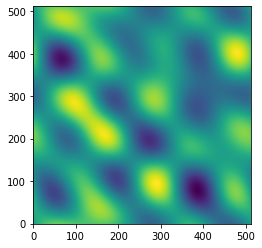

In [111]:
TRUE_HF = HarmonicFn(
    HarmonicFnConfig(
        input_dim=2,
        freq_limit=3,
        num_components=16,
    )
)
TRUE_HF.viz_2d(side_samples=512, pad=(0, 0));

In [146]:
dm = HypercubeDataModule(
    fn=TRUE_HF,
    input_dim=TRUE_HF.cfg.input_dim,
    n_train=10000,
    n_val=1024,
    train_seed=-1,
    val_seed=100,
    num_workers=0,
    batch_size=256,
)
dm.setup()

xs_train = dm.train_ds.tensors[0].numpy().astype(np.float64)
ys_train = dm.train_ds.tensors[1].numpy().astype(np.float64)

fn_hat = ChebPoly.construct_via_lstsq(
    xs=xs_train,
    ys=ys_train,
    deg_limit=12,
    freq_limit=3,
    hf_lambda=0,
)

print(get_mse(model=fn_hat, dl=dm.train_dataloader()))
print(get_mse(model=fn_hat, dl=dm.val_dataloader()))

0.0003574392758309841
0.00045155774569138885


In [140]:
bw_loss.high_freq_norm_mcls(
    fn=fn_hat,
    input_dim=fn_hat.cfg.input_dim,
    freq_limit=3,
    n_samples=100000,
    device=fn_hat.device,
)

tensor(1.2192e-05)

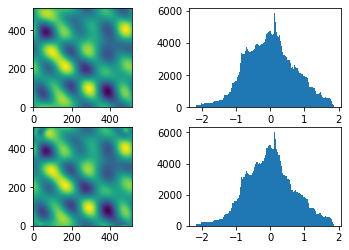

In [120]:
plt.subplot(2, 2, 1)
img = TRUE_HF.viz_2d(side_samples=512, pad=(0, 0), value=0.42)

plt.subplot(2, 2, 2)
plt.hist(img.flatten(), bins=128)

plt.subplot(2, 2, 3)
img = fn_hat.viz_2d(side_samples=512, pad=(0, 0), value=0.42)

plt.subplot(2, 2, 4)
plt.hist(img.flatten(), bins=128);

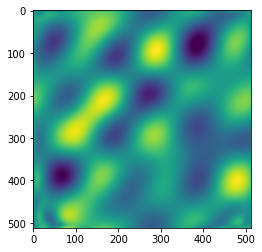

In [121]:
plt.hist(img.flatten().clip(-10, 10), bins=64);
plt.imshow(img.clip(-2, 2.5));

In [122]:
DATA = dict()

In [123]:
DATA["hf2"] = run_lstsq_exp(
    ns=[x for x in range(1, 100)] + [200, 400, 800],
    true_fn=TRUE_HF,
    estimator=lambda xs, ys: HarmonicFn.construct_via_lstsq(
        xs=xs,
        ys=ys,
        freq_limit=3,
    ),
)

100%|██████████| 102/102 [00:04<00:00, 22.13it/s]


In [161]:
DATA["cp16-f3-lam0"] = run_lstsq_exp(
    ns=[x for x in range(10, 5000, 50)] + [x for x in range(5000, 20000, 1000)],
    true_fn=TRUE_HF,
    estimator=lambda xs, ys: ChebPoly.construct_via_lstsq(
        xs=xs,
        ys=ys,
        deg_limit=16,
        freq_limit=3,
        hf_lambda=0,
    ),
    n_trials=1,
)

100%|██████████| 115/115 [02:07<00:00,  1.11s/it]


In [162]:
DATA["cp16-f3-lam1"] = run_lstsq_exp(
    ns=[x for x in range(10, 5000, 50)] + [x for x in range(5000, 20000, 1000)],
    true_fn=TRUE_HF,
    estimator=lambda xs, ys: ChebPoly.construct_via_lstsq(
        xs=xs,
        ys=ys,
        deg_limit=16,
        freq_limit=3,
        hf_lambda=1,
    ),
    n_trials=1,
)

100%|██████████| 115/115 [02:09<00:00,  1.12s/it]


In [163]:
def plot_errorbar(
    xs: np.ndarray,
    ys: np.ndarray,
    lo_q: float = 0,
    mid_q: float = 0.5,
    hi_q: float = 1,
    **plt_kwargs
):    
    lo  = np.quantile(ys, lo_q, axis=-1)
    mid = np.quantile(ys, mid_q, axis=-1)
    hi  = np.quantile(ys, hi_q, axis=-1)
        
    plt.errorbar(
        x=xs[mid != np.nan],
        y=mid[mid != np.nan],
        yerr=np.stack([mid-lo, hi-mid])[:, mid != np.nan],
        **plt_kwargs
    )

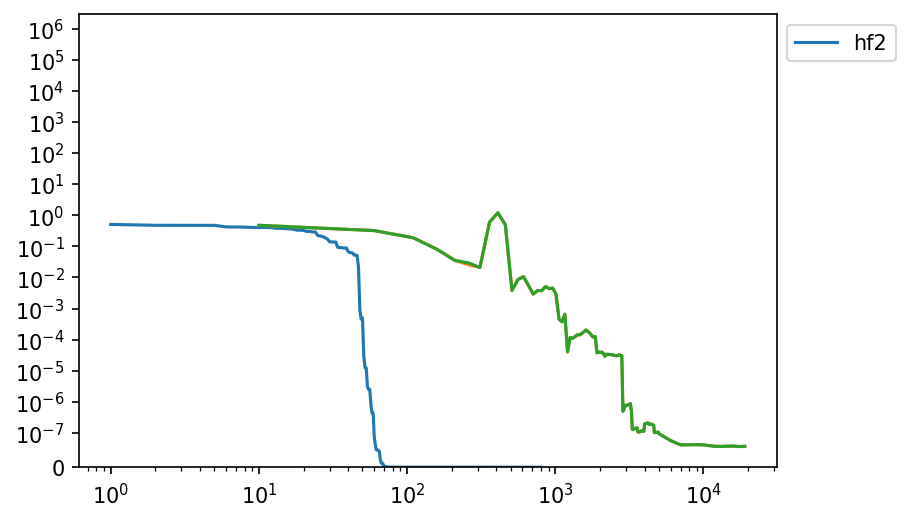

In [165]:
plt.figure(dpi=150)

plt.plot(DATA["hf2"].ns, DATA["hf2"].val_mses, label="hf2")

plot_errorbar(
    xs=DATA["cp16-f3-lam0"].ns, ys=DATA["cp16-f3-lam0"].val_mses,
    lo_q=0.5, mid_q=0.5, hi_q=0.5,
)
plot_errorbar(
    xs=DATA["cp16-f3-lam1"].ns, ys=DATA["cp16-f3-lam1"].val_mses,
    lo_q=0.5, mid_q=0.5, hi_q=0.5,
)

plt.xscale("log");
plt.yscale("symlog", linthresh=1e-7); plt.ylim(0, 3e6)
plt.legend(loc="upper left", bbox_to_anchor=(1, 1));